# ComposeGlide Demo

In [1]:
from compose_glide import ComposeGlide
from matplotlib import pyplot as plt

/Users/deniskrylov/Developer/University/gm-project 2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
compose_glide = ComposeGlide(model_name='glide_faces', verbose=True)
print(compose_glide)

            ComposeGLIDE Instance Configuration             
Device:                        mps                         
Verbose:                       True                        
------------------------------------------------------------
Base Model                                                  
  Parameters:                  385,030,726                 
  FP16 Enabled:                False                       
  Timestep Respacing:          100                         
  Image Size:                  64                          
------------------------------------------------------------
Upsampler Model                                             
  Parameters:                  398,361,286                 
  FP16 Enabled:                False                       
  Timestep Respacing:          100                         
  Image Size:                  256                         


In [15]:
PROMPT = "A pink sky in the horizon and A sailboat at the sea and Overwater bungalows"
# PROMPT = "A man"
NUM_IMAGES = 1
UPSAMPLE = False

In [16]:
print(f"Generating {NUM_IMAGES} image(s) for prompt: '{PROMPT}'.")
result, attention_data = compose_glide.generate(
    PROMPT, 
    num_images=NUM_IMAGES, 
    upsample=UPSAMPLE, 
    upsample_temp=0.995,
    save_intermediate_steps=10,
    return_attention_maps=True
)

Generating 1 image(s) for prompt: 'A pink sky in the horizon and A sailboat at the sea and Overwater bungalows'.
CLIP model loaded from cache: clip_model_cache
Using prompts: ['a pink sky in the horizon', 'a sailboat at the sea', 'overwater bungalows'] with weights: [5.870139232222607, 5.6447427812976505, 6.485117986479742]
Generating base image 1/1...


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


<Figure size 800x800 with 0 Axes>

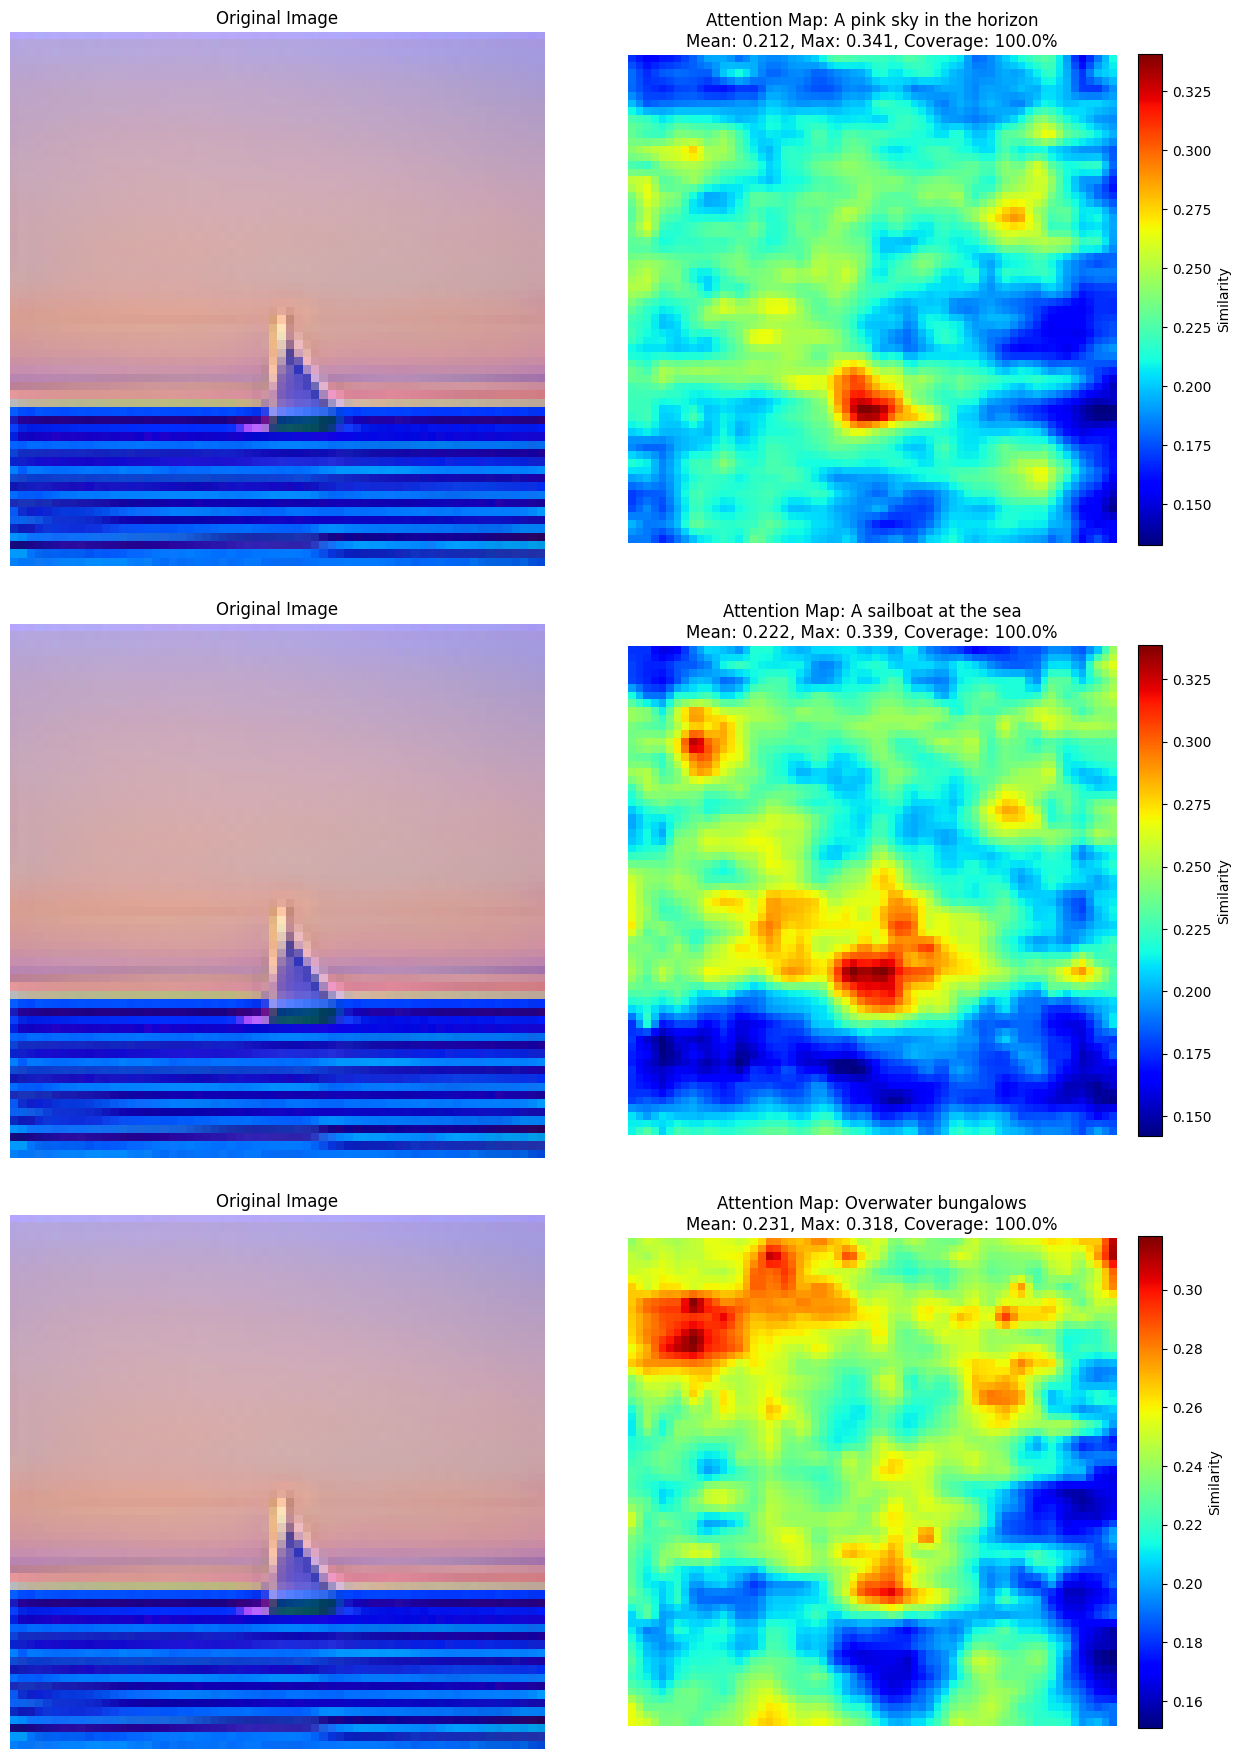

Attention map 1 displayed


In [17]:
if result.nelement() > 0:
    
    # Check if attention_data exists and has the right structure
    has_attention = attention_data is not None and len(attention_data) == len(result)
    
    for i, sample_tensor in enumerate(result):
        # Only show attention maps if they exist
        if has_attention:
            attn_maps = attention_data[i]
            
            # Create a figure for attention maps only
            plt.figure(figsize=(8, 8))
            
            # Visualize attention maps
            compose_glide.visualize_attention_maps(
                sample_tensor, 
                attn_maps,
                PROMPT,
                output_path=None,
                show_plot=False
            )
            
            plt.tight_layout()
            plt.show()
            
            print(f"Attention map {i+1} displayed")
        else:
            print("Couldn't load the attention map")
            
        # Display the original image separately if needed
        # (Removed as per request)
else:
    print("No images were generated.")